## Part 1: Creating A Repository And Working With Data


This tutorial will review the first steps of working with a hangar repository. 

To fit with the beginner's theme, we will use the MNIST dataset. Later examples will show off how to work with much more complex data.

In [1]:
from hangar import Repository

import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

from tqdm import tqdm

### Creating & Interacting with a Hangar Repository

Hangar is designed to “just make sense” in every operation you have to perform.
As such, there is a single interface which all interaction begins with: the
``Repository`` object.

Weather a hangar repository exists at the path you specify or not, just tell
hangar where it should live!

#### Intitializing a repository

The first time you want to work with a new repository, the ``init()`` method
must be called. This is where you provide hangar with your name and email
address (to be used in the commit log), as well as implicitly confirming that
you do want to create the underlying data files hangar uses on disk.

In [2]:
repo = Repository(path='/Users/rick/projects/tensorwerk/hangar/dev/mnist/')

# First time a repository is accessed only!
# Note: if you feed a path to the `Repository` which does not contain a pre-iniitlized hangar repo, 
# when the Repository object is initialized it will let you know that you need to run `init()`

repo.init(user_name='Rick Izzo', user_email='rick@tensorwerk.com')

'/Users/rick/projects/tensorwerk/hangar/dev/mnist/.hangar'

#### Checking out the repo for writing

A repository can be checked out in two modes:

1. write-enabled: applies all operations to the staging area’s current
   state. Only one write-enabled checkout can be active at a different time,
   must be closed upon last use, or manual intervention will be needed to remove
   the writer lock.

2. read-only: checkout a commit or branch to view repository state as it
   existed at that point in time.
   
#### Lots of useful information is in the ipython `__repr__`

If you're ever in doubt about what the state of the object your working
on is, just call it's reps, and the most relevant information will be
sent to your screen!

In [42]:
co = repo.checkout(write=True)
co

Hangar WriterCheckout                
    Writer       : True                
    Base Branch  : master                
    Num Datacells : 2                
    Num Metadata : 0


#### A checkout allows access to `datacells` and `metadata`

The `datacell` and `metadata` attributes of a checkout provide
the interface to working with all of the data on disk!

In [43]:
co.datacells

Hangar Datacells                
    Writeable: True                
    Datacell Names / Partial Remote References:                
      - train_images / False
      - train_labels / False

In [5]:
co.metadata

Hangar Metadata                
    Writeable: True                
    Number of Keys: 0


### Before data can be added to a repository, a datacell must be initialized.

We're going to first load up a the MNIST pickled dataset so it can be added to
the repo!

In [9]:
# Load the dataset
with gzip.open('/Users/rick/projects/tensorwerk/hangar/dev/data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='bytes')

def rescale(array):
    array = array * 256
    rounded = np.round(array)
    return rounded.astype(np.uint8())

sample_trimg = rescale(train_set[0][0])
sample_trlabel = np.array([train_set[1][0]])
trimgs = rescale(train_set[0])
trlabels = train_set[1]

#### Before data can be added to a repository, a datacell must be initialized. 

A Datacell is a named grouping of data samples where each sample shares a
number of similar attributes and array properties. See the docstrings in
`co.datacells.init_datacell`:

```
Initializes a datacell in the repository.

Datacells are groups of related data pieces (samples). All samples within
a datacell have the same data type, and number of dimensions. The size of
each dimension can be either fixed (the default behavior) or variable
per sample.

For fixed dimension sizes, all samples written to the datacell must have
the same size that was initially specified upon datacell initialization.
Variable size datacells on the other hand, can write samples with
dimensions of any size less than a maximum which is required to be set
upon datacell creation.

Parameters
----------
name : str
    The name assigned to this datacell.
shape : Union[int, Tuple[int]]
    The shape of the data samples which will be written in this datacell.
    This argument and the `dtype` argument are required if a `prototype`
    is not provided, defaults to None.
dtype : np.dtype
    The datatype of this datacell. This argument and the `shape` argument
    are required if a `prototype` is not provided., defaults to None.
prototype : np.ndarray
    A sample array of correct datatype and shape which will be used to
    initialize the datacell storage mechanisms. If this is provided, the
    `shape` and `dtype` arguments must not be set, defaults to None.
named_samples : bool, optional
    If the samples in the datacell have names associated with them. If set,
    all samples must be provided names, if not, no name will be assigned.
    defaults to True, which means all samples should have names.
variable_shape : bool, optional
    If this is a variable sized datacell. If true, a the maximum shape is
    set from the provided `shape` or `prototype` argument. Any sample
    added to the datacell can then have dimension sizes <= to this
    initial specification (so long as they have the same rank as what
    was specified) defaults to False.
backend : DEVELOPER USE ONLY. str, optional, kwarg only
    Backend which should be used to write the datacell files on disk.

Returns
-------
:class:`DatacellDataWriter`
    instance object of the initialized datacell.

Raises
------
ValueError
    If provided name contains any non ascii, non alpha-numeric characters.
ValueError
    If required `shape` and `dtype` arguments are not provided in absence of
    `prototype` argument.
ValueError
    If `prototype` argument is not a C contiguous ndarray.
ValueError
    If rank of maximum tensor shape > 31.
ValueError
    If zero sized dimension in `shape` argument
ValueError
    If the specified backend is not valid.
```

In [8]:
co.datacells.init_datacell(name='mnist_training_images', prototype=trimgs[0])

Hangar DatacellDataWriter                 
    Datacell Name             : mnist_training_images                
    Schema Hash              : 976ba57033bb                
    Variable Shape           : False                
    (max) Shape              : (784,)                
    Datatype                 : <class 'numpy.uint8'>                
    Named Samples            : True                
    Access Mode              : a                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


In [9]:
co.datacells['mnist_training_images']

Hangar DatacellDataWriter                 
    Datacell Name             : mnist_training_images                
    Schema Hash              : 976ba57033bb                
    Variable Shape           : False                
    (max) Shape              : (784,)                
    Datatype                 : <class 'numpy.uint8'>                
    Named Samples            : True                
    Access Mode              : a                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


### Interaction 

When a datacell is initialized, a datacell accessor object will be returned,
however, depending on your use case, this may or may not be the most convenient
way to access a datacell.

In general, we have implemented a full ``dict`` mapping interface on top of all
object. To access the ``'mnist_training_images'`` datacell you can just use a
dict style access like the following (note: if operating in ipython/jupyter, the
datacell keys will autocomplete for you).

In [10]:
co.datacells['mnist_training_images']

Hangar DatacellDataWriter                 
    Datacell Name             : mnist_training_images                
    Schema Hash              : 976ba57033bb                
    Variable Shape           : False                
    (max) Shape              : (784,)                
    Datatype                 : <class 'numpy.uint8'>                
    Named Samples            : True                
    Access Mode              : a                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


In [11]:
train_dcell = co.datacells['mnist_training_images']

the full dictionary style mapping interface is implemented

#### Adding Data

To add data to a named datacell, we can use dict-style setting, or the
``.add`` method.

In [12]:
train_dcell['0'] = trimgs[0]
train_dcell.add(data=trimgs[1], name='1')

train_dcell['51'] = trimgs[51]

#### How many samples are in the datacell?

In [13]:
len(train_dcell)

3

#### Containment Testing

In [14]:
'hi' in train_dcell

False

In [15]:
'0' in train_dcell

True

#### Dictionary Style Retrieval for known keys

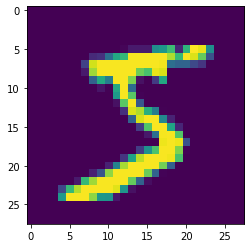

In [16]:
out = train_dcell['0']
plt.imshow(out.reshape(28, 28))

In [17]:
train_dcell

Hangar DatacellDataWriter                 
    Datacell Name             : mnist_training_images                
    Schema Hash              : 976ba57033bb                
    Variable Shape           : False                
    (max) Shape              : (784,)                
    Datatype                 : <class 'numpy.uint8'>                
    Named Samples            : True                
    Access Mode              : a                
    Number of Samples        : 3                
    Partial Remote Data Refs : False


### Dict style iteration supported out of the box

0
1
51


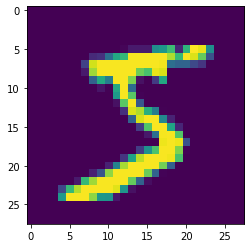

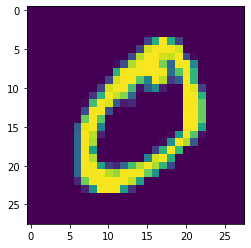

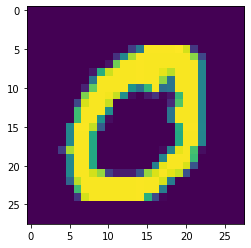

In [18]:
for k in train_dcell:   
    # equivalent method: for k in train_dcell.keys():
    print(k)
    
    
for v in train_dcell.values():
    plt.imshow(v.reshape(28, 28))
    plt.show()
    
myDict = {}
for k, v in train_dcell.items():
    myDict[k] = v

### Performance

Once you’ve completed an interactive exploration, be sure to use the context
manager form of the ``.add`` and ``.get`` methods!

In order to make sure that all your data is always safe in Hangar, the backend
diligently ensures that all contexts (operations which can somehow interact
with the record structures) are opened and closed appropriately. When you use the
context manager form of a datacell object, we can offload a significant amount of
work to the python runtime, and dramatically increase read and write speeds.

Most datacells we’ve tested see an increased throughput differential of 250% -
500% for writes and 300% - 600% for reads when comparing using the context
manager form vs the naked form!

In [10]:
import time

# ------------------ Context Manager Form ----------------------


dcell_trimgs = co.datacells.init_datacell(name='train_images', prototype=sample_trimg)
dcell_trlabels = co.datacells.init_datacell(name='train_labels', prototype=sample_trlabel)

print(f'beginning non-context manager form')
start_time = time.time()
pbar = tqdm(total=trimgs.shape[0], leave=True)
for idx, img in enumerate(trimgs):
    if (idx % 500 == 0):
        pbar.update(500)

    dcell_trimgs.add(data=img, name=str(idx))
    dcell_trlabels.add(data=np.array([trlabels[idx]]), name=str(idx))
        
pbar.close()
print(f'Finished non-context manager form in: {time.time() - start_time} seconds')

co.reset_staging_area()
co.close()

# ----------------- Non-Context Manager Form ----------------------

co = repo.checkout(write=True)

dcell_trimgs = co.datacells.init_datacell(name='train_images', prototype=sample_trimg)
dcell_trlabels = co.datacells.init_datacell(name='train_labels', prototype=sample_trlabel)

print(f'beginning context manager form')
start_time = time.time()
pbar = tqdm(total=trimgs.shape[0], leave=True)
with dcell_trimgs, dcell_trlabels:
    for idx, img in enumerate(trimgs):
        if (idx % 500 == 0):
            pbar.update(500)

        dcell_trimgs.add(data=img, name=str(idx))
        dcell_trlabels.add(data=np.array([trlabels[idx]]), name=str(idx))

        pbar.close()
print(f'Finished context manager form in: {time.time() - start_time} seconds')

  0%|          | 0/50000 [00:00<?, ?it/s]

beginning non-context manager form


100%|██████████| 50000/50000 [01:29<00:00, 570.33it/s]


Finished non-context manager form in: 90.59357118606567 seconds


  1%|          | 500/50000 [00:00<00:05, 9598.43it/s]

beginning context manager form


Finished context manager form in: 20.370257139205933 seconds


Clearly, the context manager form is far and away superior, however we fell that
for the purposes of interactive use that the "Naked" form is valubal to the
average user!

### Commiting Changes

Once you have made a set of changes you wan't to commit, just simply call the `commit()` method (and pass in a message)!

In [21]:
co.commit('hello world, this is my first hangar commit')

'd2a9e7559252fba729694dd31f3474710b9153e9'

The returned value (`'d2a9e7559252fba729694dd31f3474710b9153e9'`) is the commit hash of this commit. It
may be useful to assign this to a variable and follow this up by creating a
branch from this commit! (Branching to be covered in the next round of
tutorials)

#### Don't Forget to Close the Write-Enabled Checkout to Release the Lock!

We mentioned in `Checking out the repo for writing`_ that when a
``write-enabled`` checkout is created, it places a lock on writers until it is
closed. If for whatever reason the program terminates without closing the
write-enabled checkout, this lock will persist (forever technically, but
realistically until it is manually freed).

Luckily, preventing this issue from occurring is as simple as calling
``close()``!

In [34]:
# Just call...

co.close()

#### But if you did forget, and you recieve a `PermissionError` next time you open a checkout

```
PermissionError: Cannot aquire the writer lock. Only one instance of
a writer checkout can be active at a time. If the last checkout of this 
repository did not properly close, or a crash occured, the lock must be
manually freed before another writer can be instantiated.
```

This is a dangerous operation, and is one of the only ways where a user can put
data in their repository at risk! If another python process is still holding the
lock, do NOT force the release. Kill the process (that's totally fine to do at
any time, then force the lock release).

In [35]:
repo.force_release_writer_lock()

True

### Inspecting state from the top!

After your first commit, the summary and log methods will begin to work, and you can either print the stream to the console (as shown below), or you can 
dig deep into the internal of how hangar thinks about your data! (To be covered in an advanced tutorial later on). 

The point is, regardless of your level of interaction with a live hangar repository, all level of state is accessable from the top, and in general has been built to be the only way to directly access it!

In [36]:
repo.summary()

Summary of Contents Contained in Data Repository 
 
| Repository Info 
|----------------- 
|  Base Directory: /Users/rick/projects/tensorwerk/hangar/dev/mnist 
|  Disk Usage: 69.93 MB 
 
| Commit Details 
------------------- 
|  Commit: 25a6ca6b84112ab209c1916c29ee1075fe8a6b52 
|  Created: Mon Aug  5 23:44:26 2019 
|  By: Rick Izzo 
|  Email: rick@tensorwerk.com 
|  Message: commit on testbranch 
 
| DataSets 
|----------------- 
|  Number of Named Datacells: 3 
|
|  * Datacell Name: mnist_training_images 
|    Num Arrays: 3 
|    Details: 
|    - schema_hash: 976ba57033bb 
|    - schema_dtype: 2 
|    - schema_is_var: False 
|    - schema_max_shape: (784,) 
|    - schema_is_named: True 
|    - schema_default_backend: 00 
|
|  * Datacell Name: train_images 
|    Num Arrays: 50000 
|    Details: 
|    - schema_hash: 976ba57033bb 
|    - schema_dtype: 2 
|    - schema_is_var: False 
|    - schema_max_shape: (784,) 
|    - schema_is_named: True 
|    - schema_default_backend: 00 
|
|  * D

In [37]:
repo.log()

* 25a6ca6b84112ab209c1916c29ee1075fe8a6b52 (testbranch) : commit on testbranch
* d2a9e7559252fba729694dd31f3474710b9153e9 : hello world, this is my first hangar commit
